<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/Test_API_VNQuant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thử nghiệm thư viện vnquant để đồng bộ dữ liệu và xây dựng mô hình dự đoán giá chứng khoán

Model sử dụng tensorflow: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [16]:
!pip install git+https://github.com/phamdinhkhanh/vnquant

  Cloning https://github.com/phamdinhkhanh/vnquant to /tmp/pip-req-build-8dvqxr1s
  Running command git clone -q https://github.com/phamdinhkhanh/vnquant /tmp/pip-req-build-8dvqxr1s
     |████████████████████████████████| 6.3MB 5.3MB/s 
  Created wheel for vnquant: filename=vnquant-0.0.2-cp37-none-any.whl size=9759 sha256=e8e500318f7cfb3ec5da79be3660e23b681f8e93e11a327c88460a9ab88fd2db
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kz8jky9/wheels/70/f7/51/ab84791f03861a32e07cb59321d8911fb994eee39e08f2b77b
  Created wheel for pypandoc: filename=pypandoc-1.5-cp37-none-any.whl size=17036 sha256=1d5c435e8d9b8436b2e4392519ff661d8ea96bea3e594bbeb9b28841bca232bb
  Stored in directory: /root/.cache/pip/wheels/bb/7d/d6/2f9af55e800d37e42e546106bcbd36a86e24e725e303d17e04
Successfully built vnquant pypandoc
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [164]:
import vnquant.DataLoader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [217]:
loader = web.DataLoader('MBB', '2020-02-02','2021-05-28', data_source='VND')
data = loader.download()
data.head()

2021-05-29 18:23:38,851 : INFO : data MBB from 2020-02-02 to 2021-05-28 have already cloned!


Attributes,high,low,open,close,avg,volume
Symbols,MBB,MBB,MBB,MBB,MBB,MBB
date,,,,,,
2020-02-03,20.80,19.50,20.15,20.35,20.10,14421110.0
2020-02-04,21.55,20.15,20.65,21.15,20.76,9596660.0
2020-02-05,21.60,21.05,21.40,21.15,21.36,8036603.0
2020-02-06,22.00,20.90,21.15,21.80,21.54,13166109.0
2020-02-07,21.80,21.40,21.75,21.40,21.59,8050600.0


In [218]:
data.columns = ['high', 'low', 'open', 'close', 'avg', 'volumne']

In [219]:
data['stdev'] = data[['high', 'low', 'open', 'close']].apply(lambda x: np.std(x), axis = 1)
data.head()

,high,low,open,close,avg,volumne,stdev
date,,,,,,,
2020-02-03,20.80,19.50,20.15,20.35,20.10,14421110.0,0.467707
2020-02-04,21.55,20.15,20.65,21.15,20.76,9596660.0,0.526189
2020-02-05,21.60,21.05,21.40,21.15,21.36,8036603.0,0.215058
2020-02-06,22.00,20.90,21.15,21.80,21.54,13166109.0,0.451906
2020-02-07,21.80,21.40,21.75,21.40,21.59,8050600.0,0.188331


TỰ WINDOWING

In [220]:
rnum = data.shape[0]

In [248]:
[i for i in [1,2] for t in [2,3]]

[1, 1, 2, 2]

In [258]:
# Xử dụng dữ liệu trong 60 ngày, dự đoán giá trong 15 ngày tiếp theo
def get_cursor_change(data, point_index, cycle):
  start = data.iloc[(point_index - cycle),:]
  end = data.iloc[point_index,:]
  return (end - start )/start

def get_features(data, point_index ):
  ft_7d = get_cursor_change( data, point_index, 7)
  ft_14d = get_cursor_change( data, point_index, 14)
  ft_30d = get_cursor_change( data, point_index, 30)
  ft_60d = get_cursor_change( data, point_index, 60)
  features = pd.concat([ft_7d, ft_14d, ft_30d, ft_60d])
  features.index = [i+t for t in ['_7d', '_14d', '_30d', '_60d'] for i in data.columns]
  return features

def get_features_and_label(data, point_index, label = 'close'):
  features = get_features(data, point_index)

  labels = get_cursor_change(data[[label]], point_index+15, 15)
  labels.index = [label+'_add_15d']

  return pd.concat([features, labels])

def get_training_dataset(data):
  train_series = []
  for i in range(data.shape[0]-60):
    point_index = i+60
    try:
      train_series.append(get_features_and_label( data, point_index ))
    except: pass
  return pd.concat(train_series, axis = 1).T


In [259]:
df_windowed = get_training_dataset( df)

In [260]:
split = int(df_windowed.shape[0]*0.7)
train_df = df_windowed.iloc[:split]
valid_df = df_windowed.iloc[split:]

In [261]:
train_df

,high_7d,low_7d,open_7d,close_7d,avg_7d,volumne_7d,stdev_7d,high_14d,low_14d,open_14d,close_14d,avg_14d,volumne_14d,stdev_14d,high_30d,low_30d,open_30d,close_30d,avg_30d,volumne_30d,stdev_30d,high_60d,low_60d,open_60d,close_60d,avg_60d,volumne_60d,stdev_60d,close_add_15d
0,-0.102041,-0.100840,-0.079498,-0.114286,-0.107438,-0.412321,-0.239114,-0.017857,-0.009259,0.000000,-0.013636,-0.008264,0.206043,-0.120547,-0.166667,-0.144000,-0.147287,-0.178030,-0.167951,0.398569,-0.566987,-0.243986,-0.218978,-0.243986,-0.225000,-0.221902,0.075621,-0.659920,0.115207
1,-0.109312,-0.084746,-0.117886,-0.072034,-0.090909,-0.676261,-0.699511,-0.063830,-0.009174,-0.013636,-0.047826,-0.047203,-0.782092,-0.774554,-0.169811,-0.132530,-0.132000,-0.170455,-0.153727,-0.027372,-0.789648,-0.214286,-0.191011,-0.225000,-0.217857,-0.202050,-0.447068,-0.719117,0.132420
2,-0.052174,-0.022727,-0.026786,-0.022727,-0.032258,-0.738377,-0.633492,-0.064378,-0.040179,-0.060345,-0.065217,-0.052632,-0.546541,-0.570331,-0.174242,-0.160156,-0.151751,-0.173077,-0.166023,0.548966,-0.518068,-0.226950,-0.215328,-0.215827,-0.237589,-0.224695,3.427437,-0.547733,0.176744
3,-0.056769,0.019139,0.023810,-0.040359,-0.002791,-0.852421,-0.868863,-0.076923,-0.061674,-0.065217,-0.057269,-0.068636,-0.650296,-0.610751,-0.166023,-0.144578,-0.153543,-0.173745,-0.162500,-0.375072,-0.730320,-0.239437,-0.202247,-0.194757,-0.241135,-0.226551,0.232203,-0.860788,0.228972
4,-0.039648,-0.027397,-0.044643,-0.018018,-0.030603,-0.527480,-0.218787,-0.043860,-0.040541,-0.061404,-0.031111,-0.040962,-0.484064,-0.084367,-0.158301,-0.151394,-0.154150,-0.141732,-0.150631,-0.919271,-0.227263,-0.232394,-0.228261,-0.235714,-0.224199,-0.230714,1.640469,-0.204018,0.169725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.017291,-0.011765,-0.014663,-0.002890,0.000000,0.995165,1.330758,0.135048,0.098039,0.087379,0.123779,0.116309,2.231834,2.691493,0.079511,0.076923,0.033846,0.091772,0.076441,0.597036,0.142451,0.423387,0.400000,0.394191,0.419753,0.405892,0.916192,1.299886,0.263768
147,0.000000,-0.020349,0.005797,-0.008671,-0.011507,-0.003696,0.920848,0.107256,0.097720,0.130293,0.082019,0.091487,0.058718,0.034408,0.117834,0.097720,0.105096,0.110032,0.109174,-0.461156,0.678031,0.426829,0.404167,0.427984,0.423237,0.412829,3.793628,1.257263,0.335277
148,0.000000,0.020958,-0.008596,0.011765,0.011716,-0.225427,-0.541877,0.090625,0.096463,0.105431,0.095541,0.094423,1.740893,-0.130773,0.100946,0.107143,0.119741,0.085174,0.109826,1.275367,-0.316367,0.430328,0.420833,0.435685,0.415638,0.427273,6.780353,0.843909,0.328488
149,0.005764,0.008850,-0.005780,0.011594,0.008757,-0.379818,-0.009725,0.104430,0.103226,0.095541,0.107937,0.102041,1.647448,0.353265,0.083851,0.099678,0.078370,0.100946,0.094364,0.202830,-0.233924,0.418699,0.413223,0.404082,0.436214,0.419885,2.515989,0.949359,0.295129


In [262]:
train_df.shape

(151, 29)

In [263]:
cols_ft = [i for i in train_df.columns if i !='close_add_15d']
label = 'close_add_15d'

In [264]:
model = RandomForestRegressor(min_samples_leaf = 5)

In [265]:
model.fit(train_df[ cols_ft ], train_df[label])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [266]:
# Train set evaluation
y_true = train_df[label]
y_pred = model.predict( train_df[cols_ft] )

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

0.8983270253498843
0.02427321898534686


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150
0,0.115207,0.13242,0.176744,0.228972,0.169725,0.159091,0.143498,0.101695,0.053061,0.074689,0.110204,0.150628,0.166667,0.118852,0.127049,0.074380,0.040323,-0.035573,-0.007605,0.023529,0.011765,0.035294,0.015385,0.069767,0.046332,0.000000,-0.007273,-0.060714,-0.036630,-0.040000,0.003846,0.007752,0.081967,0.007663,0.003831,0.031008,-0.003788,0.007576,-0.021739,-0.011070,...,0.026316,-0.003247,-0.032573,-0.022801,-0.072100,-0.031646,-0.006472,0.000000,-0.009464,-0.009434,0.003125,0.071875,0.088050,0.077882,0.081250,0.089744,0.123779,0.191919,0.163333,0.155405,0.127451,0.117264,0.085174,0.111465,0.155556,0.137072,0.099125,0.095376,0.098266,0.080925,0.129412,0.159420,0.135593,0.123209,0.192982,0.263768,0.335277,0.328488,0.295129,0.326923
1,0.127723,0.12071,0.136264,0.134886,0.120914,0.134981,0.132064,0.110986,0.088543,0.111437,0.110317,0.126170,0.125003,0.114471,0.102249,0.103123,0.070417,0.034665,0.032637,0.040481,0.042061,0.089629,0.073008,0.082542,0.070825,0.053902,0.016410,-0.001344,0.039286,0.014945,0.037918,0.039832,0.066736,0.033407,0.046639,0.019206,-0.003838,-0.009291,-0.001776,0.004144,...,0.004193,-0.014864,-0.019264,-0.012659,-0.017200,-0.016103,-0.007850,-0.000918,0.001521,-0.001741,0.037660,0.074029,0.096279,0.068195,0.097454,0.098623,0.114518,0.134336,0.090973,0.133400,0.120534,0.125989,0.114097,0.121391,0.091607,0.113035,0.110519,0.107348,0.094973,0.110303,0.142381,0.168214,0.131026,0.119356,0.226426,0.231962,0.219383,0.246412,0.248676,0.235754
2,-0.012516,0.01171,0.040480,0.094086,0.048811,0.024110,0.011434,-0.009291,-0.035482,-0.036749,-0.000113,0.024457,0.041664,0.004382,0.024800,-0.028743,-0.030095,-0.070238,-0.040242,-0.016952,-0.030296,-0.054335,-0.057624,-0.012774,-0.024493,-0.053902,-0.023683,-0.059371,-0.075916,-0.054945,-0.034072,-0.032080,0.015231,-0.025745,-0.042808,0.011802,0.000050,0.016867,-0.019964,-0.015214,...,0.022123,0.011617,-0.013309,-0.010143,-0.054900,-0.015543,0.001377,0.000918,-0.010985,-0.007693,-0.034535,-0.002154,-0.008228,0.009686,-0.016204,-0.008880,0.009261,0.057583,0.072361,0.022005,0.006917,-0.008725,-0.028924,-0.009926,0.063949,0.024037,-0.011394,-0.011972,0.003293,-0.029379,-0.012969,-0.008793,0.004567,0.003853,-0.033443,0.031806,0.115894,0.082077,0.046453,0.091169
3,-0.108635,0.08843,0.229030,0.410905,0.287589,0.151547,0.079678,-0.091359,-0.668704,-0.492024,-0.001027,0.162370,0.249982,0.036866,0.195200,-0.386428,-0.746345,1.974469,5.291774,-0.720453,-2.575192,-1.539502,-3.745528,-0.183098,-0.528631,-inf,3.256429,0.977870,2.072509,1.373635,-8.858703,-4.138300,0.185817,-3.359676,-11.172846,0.380609,-0.013223,2.226401,0.918321,1.374375,...,0.840663,-3.578045,0.408593,0.444829,0.761439,0.491149,-0.212762,inf,1.160738,0.815489,-11.051043,-0.029971,-0.093452,0.124374,-0.199435,-0.098947,0.074817,0.300038,0.443023,0.141597,0.054272,-0.074408,-0.339587,-0.089047,0.411100,0.175358,-0.114946,-0.125527,0.033513,-0.363035,-0.100217,-0.055159,0.033680,0.031271,-0.173297,0.120584,0.345665,0.249861,0.157398,0.278869


In [267]:
# Valid set evaluation
y_true = valid_df[label]
y_pred = model.predict( valid_df[cols_ft] )

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

-0.038344277298207
0.1801425021301275


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,0.413699,0.458886,0.427441,0.421053,0.542781,0.562500,0.490000,0.462687,0.530612,0.500000,0.380734,0.307860,0.312910,0.309735,0.171843,0.149225,0.052727,0.134935,0.175926,0.062392,-0.048333,-0.053691,-0.015306,-0.068333,-0.088235,-0.132890,-0.188648,-0.246667,-0.207770,-0.226148,-0.224283,-0.150259,-0.169381,-0.170079,-0.151713,-0.050788,-0.007092,-0.050086,-0.012522,-0.019713,0.055556,0.144033,0.232301,0.181237,0.333333,0.260870,0.172764,0.086275,0.043643,0.103846,0.042435,0.025000,0.083636,0.065217,0.063985,0.034483,0.034173,0.070018,0.110108,0.041096,0.018966,0.001733,0.043321,0.045455,0.013937,0.069027
1,0.172259,0.170046,0.130611,0.117766,0.128179,0.116107,0.090521,0.076673,0.073989,0.083372,0.076073,0.073610,0.077257,0.070402,0.071495,0.071406,0.072006,0.076954,0.072939,0.072583,0.073141,0.068763,0.067012,0.067698,0.068189,0.068464,0.068098,0.082100,0.086348,0.109241,0.125627,0.127607,0.113562,0.124703,0.100577,0.107348,0.071922,0.107286,0.103578,0.103356,0.115764,0.159925,0.181443,0.176840,0.171025,0.176966,0.184616,0.183329,0.174541,0.171493,0.172142,0.177332,0.174793,0.173895,0.174729,0.188164,0.170639,0.161905,0.172187,0.174907,0.166877,0.176195,0.180783,0.179035,0.194901,0.169301
2,0.241439,0.288840,0.296829,0.303287,0.414602,0.446393,0.399479,0.386013,0.456623,0.416628,0.304661,0.234251,0.235653,0.239332,0.100347,0.077819,-0.019278,0.057981,0.102987,-0.010191,-0.121475,-0.122455,-0.082318,-0.136031,-0.156424,-0.201354,-0.256746,-0.328766,-0.294118,-0.335389,-0.349910,-0.277866,-0.282943,-0.294782,-0.252290,-0.158136,-0.079014,-0.157373,-0.116101,-0.123069,-0.060208,-0.015893,0.050858,0.004397,0.162308,0.083904,-0.011851,-0.097054,-0.130898,-0.067646,-0.129706,-0.152332,-0.091156,-0.108678,-0.110744,-0.153681,-0.136466,-0.091887,-0.062078,-0.133811,-0.147912,-0.174462,-0.137462,-0.133580,-0.180964,-0.100275
3,0.583612,0.629437,0.694434,0.720306,0.763848,0.793587,0.815263,0.834287,0.860559,0.833256,0.800195,0.760899,0.753102,0.772701,0.583949,0.521489,-0.365626,0.429695,0.585400,-0.163339,2.513272,2.280720,5.378098,1.990695,1.772807,1.515192,1.360982,1.332836,1.415593,1.483050,1.560124,1.849246,1.670451,1.733208,1.662942,3.113643,11.141015,3.142026,9.271481,6.242949,-1.083747,-0.110340,0.218933,0.024260,0.486925,0.321631,-0.068598,-1.124948,-2.999268,-0.651410,-3.056554,-6.093282,-1.089914,-1.666389,-1.730764,-4.456743,-3.993439,-1.312333,-0.563794,-3.256078,-7.798991,-100.664351,-3.173076,-2.938770,-12.984137,-1.452695


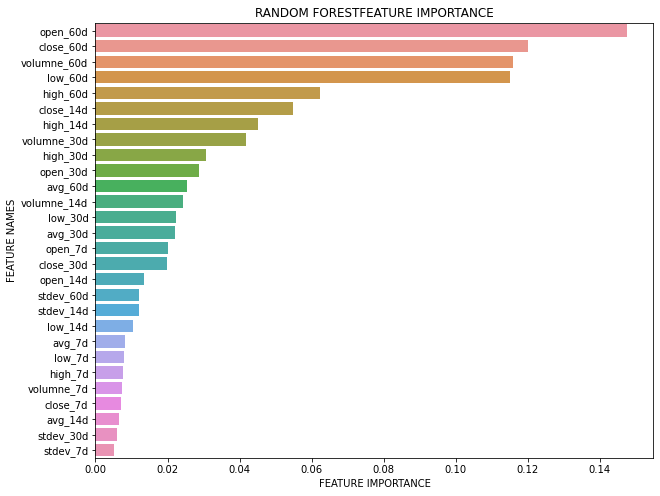

In [268]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance( model.feature_importances_, cols_ft,'RANDOM FOREST' )

In [203]:
y_pred = model.predict(valid_df[cols_ft])

In [204]:
y_true = valid_df[label]

In [205]:
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)

0.1623873450645825


In [206]:
print(r2_score(y_true, y_pred))

-0.1086197995308733


In [207]:
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.095376,0.098266,0.080925,0.129412,0.159420,0.135593,0.123209,0.192982,0.263768,0.335277,0.328488,0.295129,0.326923,0.413699,0.458886,0.427441,0.421053,0.542781,0.562500,0.490000,0.462687,0.530612,0.500000,0.380734,0.307860,0.312910,0.309735,0.171843,0.149225,0.052727,0.134935,0.175926,0.062392,-0.048333,-0.053691,-0.015306,-0.068333,-0.088235,-0.132890,-0.188648,-0.246667,-0.207770,-0.226148,-0.224283,-0.150259,-0.169381,-0.170079,-0.151713,-0.050788,-0.007092,-0.050086,-0.012522,-0.019713,0.055556,0.144033,0.232301,0.181237,0.333333,0.260870,0.172764,0.086275,0.043643,0.103846,0.042435,0.025000,0.083636,0.065217,0.063985,0.034483,0.034173,0.070018,0.110108,0.041096,0.018966,0.001733,0.043321,0.045455,0.013937,0.069027
1,0.123601,0.120806,0.121740,0.081930,0.008053,0.009693,0.007943,0.024469,0.078260,0.070912,0.101911,0.102198,0.063774,0.069371,0.117773,0.122078,0.120181,0.117188,0.118226,0.076110,0.009126,0.007911,0.008053,0.009693,0.009693,0.009126,0.006999,0.006626,0.007485,0.007485,0.006626,0.009693,0.009693,0.009693,0.006999,0.007485,0.007485,0.006999,0.006999,0.007958,0.009415,0.010546,0.045160,0.098041,0.098073,0.060503,0.067071,0.083317,-0.024895,-0.022720,-0.016804,-0.022624,0.023150,0.027267,0.022243,0.025499,0.023271,0.027366,0.023271,0.029572,0.023591,0.010655,0.002336,-0.005451,-0.016261,-0.023182,0.004628,0.028349,0.083955,0.006999,0.006236,0.008797,0.011060,0.008397,0.019185,0.065543,0.021878,0.101246,0.011005
2,-0.028225,-0.022540,-0.040815,0.047481,0.151368,0.125900,0.115266,0.168513,0.185508,0.264365,0.226578,0.192931,0.263149,0.344328,0.341113,0.305363,0.300872,0.425593,0.444274,0.413890,0.453561,0.522701,0.491947,0.371041,0.298167,0.303785,0.302736,0.165217,0.141740,0.045243,0.128309,0.166233,0.052698,-0.058027,-0.060690,-0.022791,-0.075818,-0.095234,-0.139889,-0.196606,-0.256082,-0.218316,-0.271309,-0.322324,-0.248333,-0.229884,-0.237150,-0.235029,-0.025893,0.015628,-0.033282,0.010101,-0.042863,0.028289,0.121790,0.206802,0.157966,0.305968,0.237599,0.143192,0.062684,0.032988,0.101510,0.047886,0.041261,0.106819,0.060590,0.035636,-0.049473,0.027174,0.063782,0.101311,0.030036,0.010568,-0.017452,-0.022222,0.023577,-0.087309,0.058021
3,-0.295938,-0.229376,-0.504356,0.366902,0.949489,0.928511,0.935533,0.873206,0.703299,0.788496,0.689758,0.653717,0.804927,0.832316,0.743350,0.714399,0.714570,0.784098,0.789821,0.844674,0.980277,0.985090,0.983895,0.974540,0.968514,0.970836,0.977404,0.961441,0.949842,0.858048,0.950895,0.944901,0.844636,1.200554,1.130354,1.489004,1.109533,1.079320,1.052666,1.042185,1.038169,1.050756,1.199694,1.437129,1.652696,1.357200,1.394354,1.549173,0.509833,-2.203587,0.664490,-0.806655,2.174315,0.509194,0.845569,0.890232,0.871600,0.917903,0.910795,0.828831,0.726559,0.755855,0.977506,1.128454,1.650424,1.277181,0.929041,0.556943,-1.434705,0.795191,0.910942,0.920103,0.730871,0.557239,-10.069738,-0.512959,0.518687,-6.264402,0.840562


WINDOWING THEO MẪU

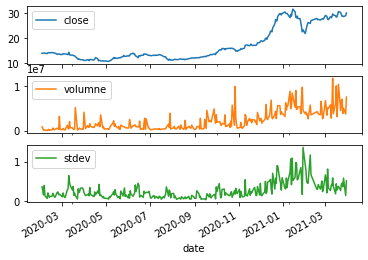

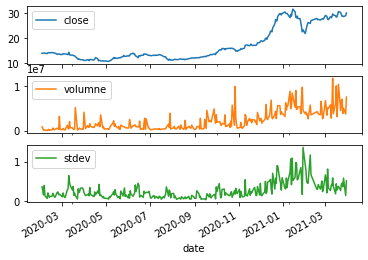

In [66]:
plot_cols = ['close', 'volumne', 'stdev']
plot_features = data[plot_cols]
plot_features.index = data.index
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:480]
plot_features.index = data.index[:480]
_ = plot_features.plot(subplots=True)

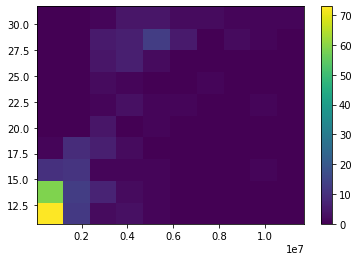

In [72]:
plt.hist2d(data['volumne'], data['close'], )
plt.colorbar()

In [73]:
df = data

In [74]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [75]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


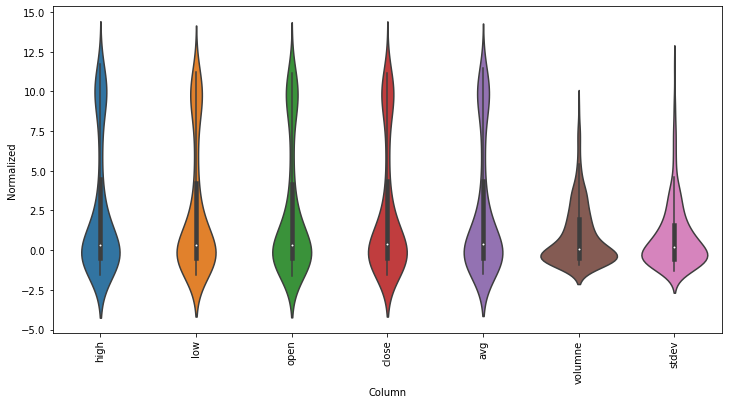

In [78]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [79]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [80]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close']

In [88]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [89]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [91]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

InvalidArgumentError: ignored